In [2]:
from sole import Sole
from solepair import SolePair
from solepaircompare import SolePairCompare
import time
import pandas as pd
import multiprocessing
import random
import util
import numpy as np

In [ ]:
# Maybe save CSVs at some point

#Q.coords.to_csv("./Q/" + Q.file_name[:-5] + ".csv")
#K.coords.to_csv("./K/" + K.file_name[:-5] + ".csv")
#Q.aligned.to_csv("./Q_aligned/" + Q.file_name[:-5] + ".csv")

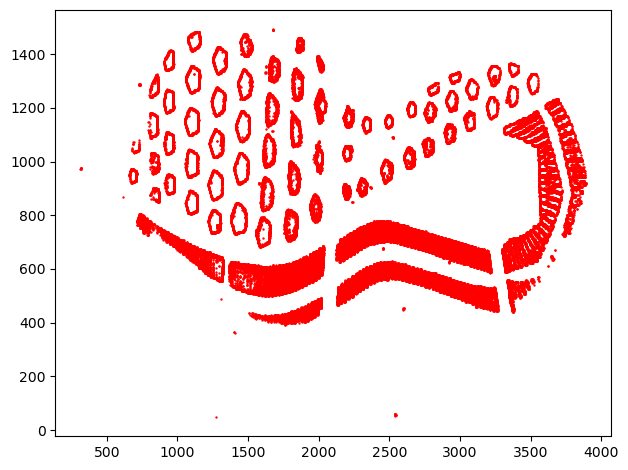

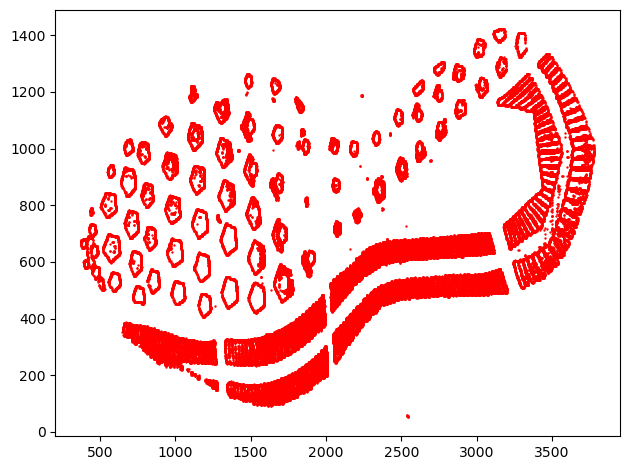

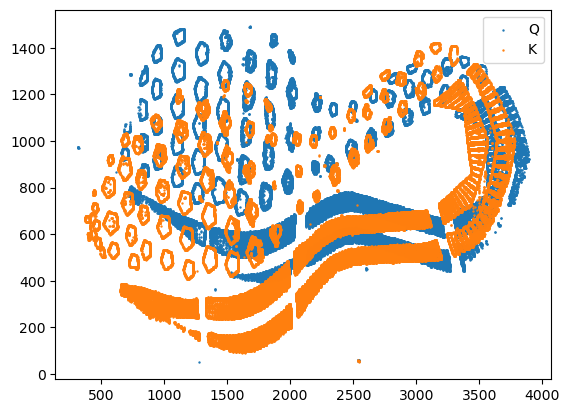

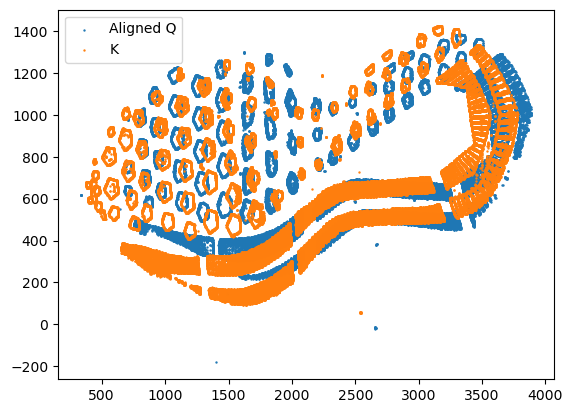

In [11]:
Q = Sole("2DScanImages/035655L_20180418_2_2_1_csafe_tpashek.tiff", border_width=160)
K = Sole("2DScanImages/094265L_20180214_2_1_1_csafe_hanrahan.tiff", border_width=160)

Q.plot()
K.plot()
pair = SolePair(Q, K, mated=True)
pair.plot()

sc = SolePairCompare(pair) # icp is called here
pair.plot(aligned=True)

row = {'qID': Q.file_name[:-5], 'kID': K.file_name[:-5], 'mated': pair.mated}

row.update(sc.min_dist())

row['q_pct'] = sc.percent_overlap(Q_as_base=True)
row['k_pct'] = sc.percent_overlap(Q_as_base=False)
row['Tx'] = pair.T[0][0]
row['Ty'] = pair.T[1][1]
row['Tz'] = pair.T[2][2]

In [ ]:
def _create_km_pairs(df, name: str):
    '''
    Documenting Known Mated Pairs data process
    '''

    kms = []
    
    df = df.sort_values(by = 'Shoe Number')
    for i in range(len(df)):
        for j in range(i+1,len(df)):
            if (df.iloc[i].loc['Shoe Number'] == df.iloc[j].loc['Shoe Number'] and
                df.iloc[i].loc['Foot'] == df.iloc[j].loc['Foot'] and
                df.iloc[i].loc['Image Number'] == df.iloc[j].loc['Image Number'] and
                df.iloc[i].loc['Visit Number'] == df.iloc[j].loc['Visit Number'] and
                df.iloc[i].loc['Shoe Size'] == df.iloc[j].loc['Shoe Size']
            ) :
                kms.append((df.iloc[i].loc['File Name'], df.iloc[j].loc['File Name']))
                break

    kms_df = pd.DataFrame(kms)
    kms_df.rename(columns = {0: 'q', 1 : 'k'}, inplace=True)
    kms_df.to_csv(name, index=False)

t1 = time.time()
_create_km_pairs(train, "KM_train.csv")
t0 = time.time()
print(t0-t1)

t1 = time.time()
_create_km_pairs(test, "KM_test.csv")
t0 = time.time()
print(t0-t1)

def _create_knm_pairs(df, name: str, size: int = 2407):
    '''
    Documenting Known Non-Mated Pairs data process
    '''
    knms = []

    for i in range(len(df)):
        non_mated_row = np.random.randint(len(df))

        while (df.iloc[i].loc['File Name'] == df.iloc[non_mated_row].loc['File Name'] or
               df.iloc[i].loc['Shoe Number'] == df.iloc[non_mated_row].loc['Shoe Number'] or
               df.iloc[i].loc['Shoe Size'] != df.iloc[non_mated_row].loc['Shoe Size'] or
               df.iloc[i].loc['Shoe Make/Model'] != df.iloc[non_mated_row].loc['Shoe Make/Model'] or
               df.iloc[i].loc['Foot'] != df.iloc[non_mated_row].loc['Foot']):
            non_mated_row = np.random.randint(len(df))
        
        knms.append((df.iloc[i].loc['File Name'], df.iloc[non_mated_row].loc['File Name']))

    knms_df = pd.DataFrame(knms).sample(size)
    knms_df = knms_df.reset_index(drop=True)
    knms_df.rename(columns = {0: 'q', 1 : 'k'}, inplace=True)
    knms_df.to_csv(name, index=False)

t1 = time.time()
_create_knm_pairs(train, "KNM_train.csv", 1734)
t0 = time.time()
print(t0-t1)

t1 = time.time()
_create_knm_pairs(test, "KNM_test.csv", 673)
t0 = time.time()
print(t0-t1)

    # conditions to satisfy knm: different file name & same size & same model & same foot & different file name;

In [362]:
km_train = pd.read_csv("KM_train.csv")
km_train['mated'] = True
km_train.to_csv("KM_train.csv")

In [363]:
km_test = pd.read_csv("KM_test.csv")
km_test['mated'] = True
km_test.to_csv("KM_test.csv")

In [364]:
knm_train = pd.read_csv("KNM_train.csv")
knm_train['mated'] = False
knm_train.to_csv("KNM_train.csv")

In [365]:
knm_test = pd.read_csv("KNM_test.csv")
knm_test['mated'] = False
knm_test.to_csv("KNM_test.csv")

In [7]:
combined_train = pd.concat([km_train, knm_train], ignore_index=True)
combined_test = pd.concat([km_test, knm_test], ignore_index=True)

In [5]:
def process_image(Q_file, K_file, mated):
    Q = Sole("2DScanImages/" + Q_file, border_width=160)
    K = Sole("2DScanImages/" + K_file, border_width=160)
    pair = SolePair(Q, K, mated=mated)
    sc = SolePairCompare(pair, icp_downsample_rate = 0.2)  # icp is called here
    
    row = {'q_file_name': Q.file_name[:-5], 
           'k_file_name': K.file_name[:-5],
           'q_number': Q.number,
           'k_number': K.number,
           'mated': pair.mated, 
           'q_model': Q.model, 
           'k_model': K.model, 
           'q_size': Q.size, 
           'k_size': K.size, 
           'q_foot': Q.foot, 
           'k_foot': K.foot}
    
    row.update(sc.min_dist())
    
    row['q_pct'] = sc.percent_overlap(Q_as_base=True)
    row['k_pct'] = sc.percent_overlap(Q_as_base=False)
    row['Tx'] = pair.T[0][0]
    row['Ty'] = pair.T[1][1]
    row['Tz'] = pair.T[2][2]
    
    return row

In [11]:
t1 = time.time()

Q_files = combined_test.q.values
K_files = combined_test.k.values
mated = combined_test.mated.values  # Value of 'mated' parameter

df = pd.DataFrame()

for i in range(len(Q_files)):
    if i % 100 == 0:
        print("progress: ", (i*100) / len(combined_test))
    try:
        row = pd.DataFrame(process_image(Q_files[i], K_files[i], mated[i]), index=[0])
        df = pd.concat([df, row], ignore_index=True)
        df.to_csv("result_test_0625.csv", index=False)
    except Exception as e:
            print("Caught error at index " + str(i) + str(e))

t0 = time.time()
print(t0-t1)


progress:  0.0
progress:  7.429420505200595
progress:  14.85884101040119
progress:  22.288261515601782
progress:  29.71768202080238
progress:  37.147102526002975
progress:  44.576523031203564
progress:  52.00594353640416
progress:  59.43536404160476
progress:  66.86478454680535
progress:  74.29420505200595
progress:  81.72362555720653
progress:  89.15304606240713
progress:  96.58246656760772
6811.899355888367


In [9]:
# Train Logs
# progress:  0.0
# progress:  0.720876585928489
# progress:  1.441753171856978
# Caught error at index 142Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required by NearestNeighbors.
# progress:  2.162629757785467
# progress:  2.883506343713956
# progress:  3.604382929642445
# progress:  4.325259515570934
# progress:  5.046136101499424
# progress:  5.767012687427912
# progress:  6.4878892733564015
# progress:  7.20876585928489
# progress:  7.929642445213379
# progress:  8.650519031141869
# progress:  9.371395617070357
# progress:  10.092272202998847
# progress:  10.813148788927336
# progress:  11.534025374855824
# progress:  12.254901960784315
# progress:  12.975778546712803
# progress:  13.696655132641292
# progress:  14.41753171856978
# progress:  15.13840830449827
# progress:  15.859284890426759
# progress:  16.580161476355247
# progress:  17.301038062283737
# progress:  18.021914648212228
# progress:  18.742791234140714
# progress:  19.463667820069205
# progress:  20.184544405997695
# progress:  20.90542099192618
# progress:  21.62629757785467
# progress:  22.347174163783162
# progress:  23.06805074971165
# progress:  23.78892733564014
# progress:  24.50980392156863
# progress:  25.230680507497116
# progress:  25.951557093425606
# progress:  26.672433679354093
# progress:  27.393310265282583
# progress:  28.114186851211073
# progress:  28.83506343713956
# progress:  29.55594002306805
# progress:  30.27681660899654
# progress:  30.997693194925027
# progress:  31.718569780853517
# progress:  32.43944636678201
# progress:  33.160322952710494
# progress:  33.88119953863899
# progress:  34.602076124567475
# progress:  35.32295271049596
# progress:  36.043829296424455
# progress:  36.76470588235294
# progress:  37.48558246828143
# progress:  38.20645905420992
# progress:  38.92733564013841
# Caught error at index 2729Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required by NearestNeighbors.
# progress:  39.648212226066896
# progress:  40.36908881199539
# progress:  41.089965397923876
# progress:  41.81084198385236
# progress:  42.53171856978086
# progress:  43.25259515570934
# progress:  43.97347174163783
# progress:  44.694348327566324
# Caught error at index 3113Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required by NearestNeighbors.
# progress:  45.41522491349481
# progress:  46.1361014994233
# Caught error at index 3224Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required by NearestNeighbors.
# progress:  46.85697808535179
# progress:  47.57785467128028
# progress:  48.298731257208765
# progress:  49.01960784313726
# progress:  49.740484429065745
# 16866.68429708481

# Test Logs

# progress:  0.0
# progress:  7.429420505200595
# progress:  14.85884101040119
# progress:  22.288261515601782
# progress:  29.71768202080238
# progress:  37.147102526002975
# progress:  44.576523031203564
# progress:  52.00594353640416
# progress:  59.43536404160476
# progress:  66.86478454680535
# progress:  74.29420505200595
# progress:  81.72362555720653
# progress:  89.15304606240713
# progress:  96.58246656760772
# 6811.899355888367